# Analyze metadata from Zenodo spreadsheets corpus
Code to calculate file sizes, analyze file names, and generate lists of record ids for file downloading and corpus sampling related to testing and interview sampling frames.

In [1]:
import re
from datetime import datetime
import json
import pandas as pd
import math
import numpy as np
import edtf
from decimal import Decimal
import matplotlib.pyplot as plt
from edtf import parse_edtf, struct_time_to_date


In [2]:
#function by Peter F: https://stackoverflow.com/questions/5194057/better-way-to-convert-file-sizes-in-python
#Zenodo seems to calculate based on SI=True
def format_bytes(bytes, unit, SI=False):
    """
    Converts bytes to common units such as kb, kib, KB, mb, mib, MB

    Parameters
    ---------
    bytes: int
        Number of bytes to be converted

    unit: str
        Desired unit of measure for output


    SI: bool
        True -> Use SI standard e.g. KB = 1000 bytes
        False -> Use JEDEC standard e.g. KB = 1024 bytes

    Returns
    -------
    str:
        E.g. "7 MiB" where MiB is the original unit abbreviation supplied
    """
    if unit.lower() in "b bit bits".split():
        return f"{bytes*8} {unit}"
    unitN = unit[0].upper()+unit[1:].replace("s","")  # Normalised
    reference = {"Kb Kib Kibibit Kilobit": (7, 1),
                 "KB KiB Kibibyte Kilobyte": (10, 1),
                 "Mb Mib Mebibit Megabit": (17, 2),
                 "MB MiB Mebibyte Megabyte": (20, 2),
                 "Gb Gib Gibibit Gigabit": (27, 3),
                 "GB GiB Gibibyte Gigabyte": (30, 3),
                 "Tb Tib Tebibit Terabit": (37, 4),
                 "TB TiB Tebibyte Terabyte": (40, 4),
                 "Pb Pib Pebibit Petabit": (47, 5),
                 "PB PiB Pebibyte Petabyte": (50, 5),
                 "Eb Eib Exbibit Exabit": (57, 6),
                 "EB EiB Exbibyte Exabyte": (60, 6),
                 "Zb Zib Zebibit Zettabit": (67, 7),
                 "ZB ZiB Zebibyte Zettabyte": (70, 7),
                 "Yb Yib Yobibit Yottabit": (77, 8),
                 "YB YiB Yobibyte Yottabyte": (80, 8),
                 }
    key_list = '\n'.join(["     b Bit"] + [x for x in reference.keys()]) +"\n"
    if unitN not in key_list:
        raise IndexError(f"\n\nConversion unit must be one of:\n\n{key_list}")
    units, divisors = [(k,v) for k,v in reference.items() if unitN in k][0]
    if SI:
        divisor = 1000**divisors[1]/8 if "bit" in units else 1000**divisors[1]
    else:
        divisor = float(1 << divisors[0])
    value = bytes / divisor
    return value

In [3]:
def parseable_date(x):
    y = parse_edtf(x)
    z = struct_time_to_date(y.lower_strict()).year
    return z

## Create dataframes for metadata

In [4]:
#load the API results, which filtered filetype:(csv OR xlsx OR tsv OR xls OR ods OR xlsb OR ots OR xlsm OR xltm OR xltx OR ogw) AND doi:zenodo AND created:{date}
with open('zenodo_API_metadata_results_2025-06-05_12-21_PM.json', 'r') as f:
#with open('zenodo_snippet.json', 'r') as f:
    data = f.read()
zenodo_dict = json.loads(data)

In [5]:
zenodo_df = pd.json_normalize(zenodo_dict)

In [6]:
zenodo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67510 entries, 0 to 67509
Columns: 123 entries, created to metadata.custom.ac:captureDevice
dtypes: bool(1), int64(10), object(112)
memory usage: 62.9+ MB


In [7]:
zenodo_df.columns

Index(['created', 'modified', 'id', 'conceptrecid', 'doi', 'conceptdoi',
       'doi_url', 'title', 'updated', 'recid',
       ...
       'metadata.custom.dwc:locality', 'metadata.custom.dwc:phylum',
       'metadata.custom.dwc:county', 'metadata.custom.dwc:order',
       'metadata.custom.dwc:scientificName', 'metadata.custom.dwc:eventDate',
       'metadata.custom.dwc:family', 'metadata.custom.dwc:genus',
       'metadata.custom.dwc:lifeStage', 'metadata.custom.ac:captureDevice'],
      dtype='object', length=123)

### Add columns used for analysis

In [8]:
#first, export the publication dates to a CSV so they can be examined in OpenRefine and issues like whitespace or non-compliant ETDF dates found.
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')
zenodo_pub_dates = zenodo_df[['id','metadata.publication_date']]
zenodo_pub_dates.to_csv(f'zenodo_pub_dates_{filetime}.csv')

In [9]:
#then, fix and replace any dates that have issues.
#three records were found to have issues with dates
zenodo_df['metadata.publication_date'] = zenodo_df['metadata.publication_date'].str.strip().replace('02_08_2024','2024-08-02')

In [10]:
#check the records that had date issues before to make sure they are fixed: 13169677,14030741, 14215531
zenodo_df.loc[zenodo_df['id'] == 13169677]['metadata.publication_date']

60939    2024-08-02
Name: metadata.publication_date, dtype: object

In [11]:
#create a column for the earliest publication year by using the EDTF library
zenodo_df['earliest_pub_year'] = zenodo_df['metadata.publication_date'].apply(lambda x: parseable_date(x))

In [12]:
#convert the date created column to a datetime format
zenodo_df['created'] = pd.to_datetime(zenodo_df['created'], format='ISO8601')

In [13]:
#create a column for the year the record was created.
zenodo_df['year_created']=pd.DatetimeIndex(zenodo_df['created']).year

## Analysis at the record level

(array([ 2679.,  5204.,  7837., 10503., 15257., 26030.]),
 array([2019.        , 2019.83333333, 2020.66666667, 2021.5       ,
        2022.33333333, 2023.16666667, 2024.        ]),
 <BarContainer object of 6 artists>)

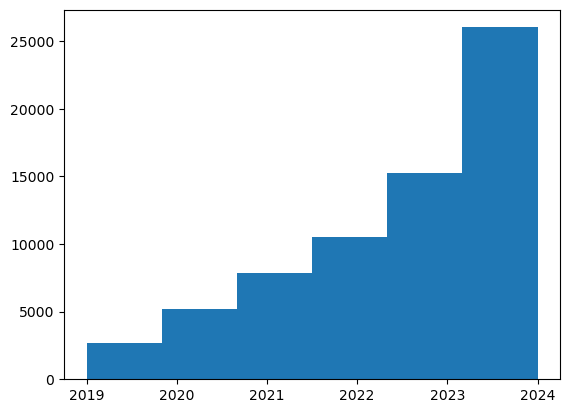

In [15]:
# The distribution of records across years
# need to plot this in a more interesting way and ensure x axis marks properly show years
plt.hist(zenodo_df.year_created, bins=6)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00,
        5.0000e+00, 7.0000e+00, 2.5000e+01, 7.8000e+01, 1.1600e+02,
        3.8800e+02, 1.6120e+04, 5.0748e+04, 9.0000e+00, 3.0000e+00]),
 array([1859.  , 1862.46, 1865.92, 1869.38, 1872.84, 1876.3 , 1879.76,
        1883.22, 1886.68, 1890.14, 1893.6 , 1897.06, 1900.52, 1903.98,
        1907.44, 1910.9 , 1914.36, 1917.82, 1921.28, 1924.74, 1928.2 ,
        1931.66, 1935.12, 1938.58, 1942.04, 1945.5 , 1948.96, 1952.42,
        1955.88, 1959.34, 1962.8 ,

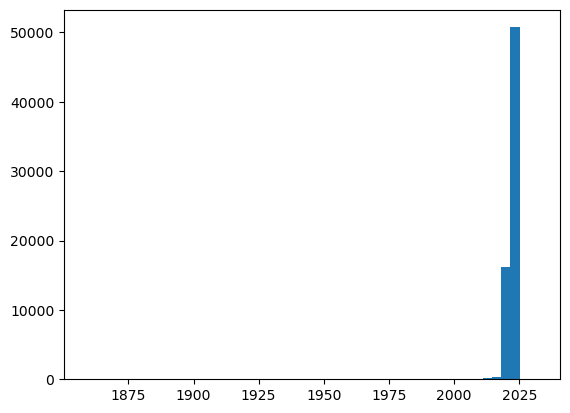

In [16]:
# The distribution of records across years
# need to plot this in a more interesting way and ensure x axis marks properly show years
plt.hist(zenodo_df.earliest_pub_year, bins=50)

In [49]:
# related to some other research entity (deposit, article, etc) in metadata.related_identifiers

zenodo_related_identifiers = zenodo_df[['id','metadata.related_identifiers']].dropna().rename({"metadata.related_identifiers": "related_identifiers"}, axis="columns")
zenodo_related_identifiers

,id,related_identifiers
2,3490855,[{'identifier': 'https://zenodo.org/record/256...
3,3542115,[{'identifier': 'https://littlemsandsailing.wo...
5,3247728,[{'identifier': 'https://comptox.epa.gov/dashb...
6,3247724,[{'identifier': 'https://comptox.epa.gov/dashb...
10,3387490,[{'identifier': '10.2903/sp.efsa.2019.en-1707'...
...,...,...
67458,14041447,[{'identifier': '10.22541/essoar.171926389.997...
67467,14174168,"[{'identifier': '10.5281/zenodo.13227745', 're..."
67472,13822585,"[{'identifier': '10.5281/zenodo.13822504', 're..."
67475,14149274,"[{'identifier': '10.1016/j.chb.2023.108128', '..."


In [55]:
zenodo_related_identifiers = zenodo_related_identifiers.reset_index(drop=True)

In [57]:
zenodo_related_identifiers

,id,related_identifiers
0,3490855,[{'identifier': 'https://zenodo.org/record/256...
1,3542115,[{'identifier': 'https://littlemsandsailing.wo...
2,3247728,[{'identifier': 'https://comptox.epa.gov/dashb...
3,3247724,[{'identifier': 'https://comptox.epa.gov/dashb...
4,3387490,[{'identifier': '10.2903/sp.efsa.2019.en-1707'...
...,...,...
9459,14041447,[{'identifier': '10.22541/essoar.171926389.997...
9460,14174168,"[{'identifier': '10.5281/zenodo.13227745', 're..."
9461,13822585,"[{'identifier': '10.5281/zenodo.13822504', 're..."
9462,14149274,"[{'identifier': '10.1016/j.chb.2023.108128', '..."


In [61]:
zenodo_related_identifiers['related_identifiers'][4]

[{'identifier': '10.2903/sp.efsa.2019.en-1707',
  'relation': 'isSupplementTo',
  'scheme': 'doi'},
 {'identifier': '10.2903/j.efsa.2019.5801',
  'relation': 'isDocumentedBy',
  'scheme': 'doi'}]

In [67]:
#https://www.geeksforgeeks.org/convert-list-like-column-elements-to-separate-rows-in-pandas/
zenodo_related_identifiers_melt = zenodo_related_identifiers.related_identifiers.apply(pd.Series).merge(zenodo_related_identifiers, right_index = True, left_index = True).drop(['related_identifiers'], axis = 1).melt(id_vars = ['id'], value_name = 'related_identifiers').drop('variable', axis=1).dropna()

In [107]:
zenodo_related_identifiers_melt = zenodo_related_identifiers_melt.reset_index(drop=True)

In [111]:
zenodo_related_identifiers_melt

,id,related_identifiers
0,3490855,{'identifier': 'https://zenodo.org/record/2561...
1,3542115,{'identifier': 'https://littlemsandsailing.wor...
2,3247728,{'identifier': 'https://comptox.epa.gov/dashbo...
3,3247724,{'identifier': 'https://comptox.epa.gov/dashbo...
4,3387490,"{'identifier': '10.2903/sp.efsa.2019.en-1707',..."
...,...,...
17058,13320893,"{'identifier': '10.11646/phytotaxa.219.2.2', '..."
17059,13320893,"{'identifier': '10.1099/ijs.0.055855-0', 'rela..."
17060,13320893,{'identifier': '10.1111/j.0022-3646.1992.00526...
17061,13320893,"{'identifier': '10.11646/phytotaxa.376.6.4', '..."


In [103]:
zenodo_related_identifiers['id']

0        3490855
1        3542115
2        3247728
3        3247724
4        3387490
          ...   
9459    14041447
9460    14174168
9461    13822585
9462    14149274
9463    14155459
Name: id, Length: 9464, dtype: int64

In [108]:
#https://datascientyst.com/normalize-json-dict-new-columns-pandas/
#https://stackoverflow.com/questions/46391291/how-to-convert-json-data-inside-a-pandas-column-into-new-columns
zenodo_relations = pd.json_normalize(zenodo_related_identifiers_melt['related_identifiers'])
#.merge(zenodo_related_identifiers_melt['id'], right_index=True)

In [110]:
zenodo_relations

,identifier,relation,scheme,resource_type
0,https://zenodo.org/record/2561723#.XPeVyNMzY_o,isReferencedBy,url,NaN
1,https://littlemsandsailing.wordpress.com/2011/...,isSupplementTo,url,NaN
2,https://comptox.epa.gov/dashboard/chemical_lis...,isSupplementTo,url,NaN
3,https://comptox.epa.gov/dashboard/chemical_lis...,isSupplementTo,url,NaN
4,10.2903/sp.efsa.2019.en-1707,isSupplementTo,doi,NaN
...,...,...,...,...
17058,10.11646/phytotaxa.219.2.2,references,doi,publication
17059,10.1099/ijs.0.055855-0,references,doi,publication
17060,10.1111/j.0022-3646.1992.00526.x,references,doi,publication
17061,10.11646/phytotaxa.376.6.4,references,doi,publication


In [109]:
zenodo_relations.reset_index(drop=True)

,identifier,relation,scheme,resource_type
0,https://zenodo.org/record/2561723#.XPeVyNMzY_o,isReferencedBy,url,NaN
1,https://littlemsandsailing.wordpress.com/2011/...,isSupplementTo,url,NaN
2,https://comptox.epa.gov/dashboard/chemical_lis...,isSupplementTo,url,NaN
3,https://comptox.epa.gov/dashboard/chemical_lis...,isSupplementTo,url,NaN
4,10.2903/sp.efsa.2019.en-1707,isSupplementTo,doi,NaN
...,...,...,...,...
17058,10.11646/phytotaxa.219.2.2,references,doi,publication
17059,10.1099/ijs.0.055855-0,references,doi,publication
17060,10.1111/j.0022-3646.1992.00526.x,references,doi,publication
17061,10.11646/phytotaxa.376.6.4,references,doi,publication


In [113]:
zenodo_related_identifiers_all = pd.concat([zenodo_relations, zenodo_related_identifiers_melt['id']], axis=1)

In [127]:
zenodo_related_identifiers_all.groupby(['relation']).count()

,identifier,scheme,resource_type,id
relation,,,,
cites,1805,1805,743,1805
compiles,201,201,62,201
continues,236,236,216,236
describes,226,226,221,226
documents,256,256,215,256
hasMetadata,19,19,19,19
hasPart,349,349,311,349
hasVersion,7,7,4,7
isCitedBy,1226,1226,943,1226


In [128]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')
zenodo_related_identifiers_all.to_csv(f'zenodo_related_identifiers_{filetime}.csv')

In [133]:
# look into extracting and analyzing keywords to get at discipline
zenodo_keywords_df = zenodo_df[['id','metadata.keywords']].dropna().explode('metadata.keywords')

In [134]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')
zenodo_keywords_df.to_csv(f'zenodo_keywords_{filetime}.csv')

In [136]:
zenodo_df[['id','metadata.subjects']].dropna()
#.dropna().explode('metadata.keywords')

,id,metadata.subjects
10,3387490,"[{'term': 'exposure assessment', 'identifier':..."
11,2613616,"[{'term': 'Food contamination', 'identifier': ..."
12,3387502,"[{'term': 'exposure assessment', 'identifier':..."
21,3339346,"[{'term': 'Contaminants', 'identifier': 'http:..."
27,3338340,"[{'term': 'avian influenza', 'identifier': 'ht..."
...,...,...
50737,11402548,"[{'term': 'pesticides', 'identifier': 'http://..."
53476,12697471,"[{'term': 'Gesundheitsberichterstattung', 'ide..."
58930,14261164,"[{'term': 'Public health surveillance', 'ident..."
58981,13943810,"[{'term': 'Gesundheitsberichterstattung', 'ide..."


## Create dataframes for files

In [ ]:
#use json_normalize to create dataframes. each record represents a file from the metadata record. at this stage, there are duplicates.
#https://stackoverflow.com/questions/52085169/valueerror-conflicting-metadata-name-name-need-distinguishing-prefix-in-pandas
#since there are two JSON fields with key 'id', need to distinguish them using record_prefix
zenodo_files_df = pd.json_normalize(zenodo_dict, record_path=[['files']],
                                       meta=['id'], record_prefix='file'
                                      )

In [ ]:
zenodo_files_df[zenodo_files_df.duplicated(keep=False)].sort_values('filekey')

In [ ]:
zenodo_files_df

In [ ]:
zenodo_files_df = zenodo_files_df.drop_duplicates().reset_index(drop=True)

In [ ]:
zenodo_files_df

In [ ]:
#https://stackoverflow.com/questions/52085169/valueerror-conflicting-metadata-name-name-need-distinguishing-prefix-in-pandas
#since there are two JSON fields with key 'id', need to distinguish them using record_prefix
zenodo_files_additional_df = pd.json_normalize(zenodo_dict_additional, record_path=[['files']],
                                       meta=['id'], record_prefix='file'
                                      )

In [ ]:
zenodo_files_additional_df[zenodo_files_additional_df.duplicated(keep=False)].sort_values('filekey')

In [ ]:
zenodo_files_additional_df

In [ ]:
#zenodo_files_additional_df = zenodo_files_additional_df.drop_duplicates().reset_index(drop=True)

In [ ]:
#zenodo_files_additional_df

In [ ]:
#concatenate the two dataframes representing files
#https://www.geeksforgeeks.org/concatenate-pandas-dataframes-without-duplicates/
zenodo_files_all_df = pd.concat([zenodo_files_df, zenodo_files_additional_df])

In [ ]:
zenodo_files_all_df

In [ ]:
#test for a known duplicate
zenodo_files_all_df.loc[zenodo_files_all_df['filekey'] == 'norm4.xlsm']

In [ ]:
#dedupe the dataframe containing all files
#https://stackoverflow.com/questions/28885073/resetting-index-after-calling-pandas-drop-duplicates
zenodo_files_all_df = zenodo_files_all_df.drop_duplicates().reset_index(drop=True)

In [ ]:
zenodo_files_all_df

In [ ]:
#test for the known duplicate
zenodo_files_all_df.loc[zenodo_files_all_df['filekey'] == 'norm4.xlsm']

### Drop the records and files that did not download

In [ ]:
# Placeholder: write code here that will drop the records and files that couldn't be downloaded,
# because of a change in record status, etc

### Add columns to the dataframes that will be used for analysis

In [ ]:
# get just the filenames and extensions
#https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html
zenodo_files_all_df['filetype'] = zenodo_files_all_df['filekey'].str.extract(r'(?:.*)(\..+)$')

In [ ]:
zenodo_files_all_df['filetype']

In [ ]:
zenodo_files_all_df['filename_noext'] = zenodo_files_all_df['filekey'].str.extract(r'(.*)(?:\..+)$')

In [ ]:
zenodo_files_all_df['filename_noext']

In [ ]:
#add columns to dataframe that convert the file size in bytes to MB and GB respectively
zenodo_files_all_df['filesize_mb'] = zenodo_files_all_df['filesize'].apply(lambda x: format_bytes(x, 'MB', SI=True))

In [ ]:
zenodo_files_all_df['filesize_gb'] = zenodo_files_all_df['filesize'].apply(lambda x: format_bytes(x, 'GB', SI=True))

In [ ]:
zenodo_files_all_df

In [ ]:
#make a list of spreadsheet file extensions
spreadsheet_filetypes = ['.csv','.tsv','.xls','.xlsb','.xlsx','.xltx','.ods','.ots','.xlsm','.xltm','.xltx','.ogw']

In [ ]:
#create a dataframe of just the spreadsheet files
#https://stackoverflow.com/questions/19960077/how-to-filter-pandas-dataframe-using-in-and-not-in-like-in-sql
zenodo_spreadsheet_files_df = zenodo_files_all_df.query('filetype in @spreadsheet_filetypes')

## Analysis of size of the corpus: counts and file size

In [ ]:
zenodo_files_all_df.loc[zenodo_files_all_df['filesize_gb'] > 50]

In [ ]:
#get some stats about the different file types. reveals that there are some poorly formed file names without proper extensions.
zenodo_files_all_df.groupby(['filetype']).agg({'filesize_mb': ['mean', 'min', 'max', 'median', 'count','sum']})

In [ ]:
#take a look at the spreadsheet files dataframe
zenodo_spreadsheet_files_df.info()

In [ ]:
#https://stackoverflow.com/questions/41286569/get-total-of-pandas-column
spreadsheet_filesize_total = zenodo_spreadsheet_files_df['filesize'].sum()
print(spreadsheet_filesize_total)

In [ ]:
format_bytes(spreadsheet_filesize_total, 'TB', SI=True)

In [ ]:
#https://stackoverflow.com/questions/41286569/get-total-of-pandas-column
spreadsheet_files_count = len(zenodo_spreadsheet_files_df.index)
print(spreadsheet_files_count)

In [ ]:
#get some basic stats about the spreadsheet files.
zenodo_spreadsheet_files_df.groupby(['filetype']).agg({'filesize': ['mean', 'min', 'max', 'median', 'count','sum']})

In [ ]:
#get some basic stats about the spreadsheet files, in GB.
zenodo_spreadsheet_files_df.groupby(['filetype']).agg({'filesize_gb': ['mean', 'min', 'max', 'median', 'count','sum']})

In [ ]:
#get some basic stats about the spreadsheet files, in MB.
zenodo_spreadsheet_files_df.groupby(['filetype']).agg({'filesize_mb': ['mean', 'min', 'max', 'median', 'count','sum']})

In [ ]:
#get just the total size of all files by filetype
#https://dnmtechs.com/calculating-percentage-of-total-with-pandas-groupby-in-python-3/
zenodo_spreadsheet_files_size_grouped = zenodo_spreadsheet_files_df.groupby(['filetype']).agg({'filesize': ['sum']})
zenodo_spreadsheet_files_size_grouped

In [ ]:
#get just the total size in GB of all files by filetype
zenodo_spreadsheet_files_df.groupby(['filetype']).agg({'filesize_gb': ['sum']})

In [ ]:
#get just the total count of all files by filetype
zenodo_spreadsheet_files_count_grouped = zenodo_spreadsheet_files_df.groupby(['filetype']).agg({'filetype': ['count']})
zenodo_spreadsheet_files_count_grouped

In [ ]:
zenodo_spreadsheet_files_size_grouped.transform(lambda x: (x / spreadsheet_filesize_total) * 100)
#.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

In [ ]:
zenodo_spreadsheet_files_count_grouped.transform(lambda x: (x / spreadsheet_files_count) * 100)

## Analysis of file names

In [ ]:
#records containing more than one spreadsheet file
# files were deposited in multiple formats, determined by looking for the same file name with different extensions

In [ ]:
zenodo_files_all_df_sorted = zenodo_files_all_df.sort_values(by=['id','filename_noext','filetype'])

In [ ]:
#https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby
zenodo_files_all_df_sorted.groupby(['id','filename_noext'], sort=False).agg({'filename_noext':'count', 'filetype': ', '.join})

In [ ]:
filename_counts = zenodo_files_all_df_sorted.groupby(['id','filename_noext'], sort=False).agg({'filename_noext':'count', 'filetype': ', '.join})

In [ ]:
filename_counts.columns

In [ ]:
filename_counts.index.name = None
filename_counts.columns=['counts', 'filetype']

In [ ]:
filename_counts = filename_counts.rename_axis(['id','filename_noext']).reset_index()

In [ ]:
filename_counts

In [ ]:
filename_duplicates = filename_counts.loc[filename_counts['counts']>1]

In [ ]:
filename_duplicates

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

filename_duplicates.to_csv(f'filename_duplicates_{filetime}.csv', index=False)

In [ ]:
filename_duplicates['filetype'].str.contains('csv')

### file names indicating spreadsheet type

In [ ]:
#https://note.nkmk.me/en/python-pandas-str-contains-match/
figure_filenames = zenodo_spreadsheet_files_df.loc[zenodo_spreadsheet_files_df['filename_noext'].str.match('(fig|figure)(\s|\W|_|-)',case=False)]

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

figure_filenames.to_csv(f'figure_filenames_{filetime}.csv', index=False)

In [ ]:
zenodo_spreadsheet_files_df.loc[zenodo_spreadsheet_files_df['filename_noext'].str.match('documentation',case=False)]

In [ ]:
zenodo_spreadsheet_files_df.loc[zenodo_spreadsheet_files_df['filename_noext'].str.contains('[ \.\$@%#&\*\(\)\!]',case=False)]

## Create lists of record ids

This section generates a list of all spreadsheet files, which can be used with zenodo_get to download all files. It also creates a sample of Excel and ODS files and a random sample of all files.

In [ ]:
excel_ods_filetypes = ['.xls','.xlsb','.xlsx','.xltx','.ods','.ots','.xlsm','.xltm','.xltx']

In [ ]:
#https://stackoverflow.com/questions/19960077/how-to-filter-pandas-dataframe-using-in-and-not-in-like-in-sql
excel_ods_files = zenodo_spreadsheet_files_df.query('filetype in @excel_ods_filetypes')

In [ ]:
excel_ods_files

In [ ]:
#https://stackoverflow.com/questions/41286569/get-total-of-pandas-column
excel_ods_filesize_total = excel_ods_files['filesize'].sum()
print(excel_ods_filesize_total)

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

excel_ods_files['id'].to_csv(f'excel_ods_{filetime}.csv', index=False)

In [ ]:
# #filetime = datetime.now()
# # filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

# zenodo_spreadsheet_files_df['id'].to_csv(f'zenodo_spreadsheet_files_{filetime}.csv', index=False)

In [ ]:
#take a random sample of a small fraction of files files
#zenodo_spreadsheet_files_df_sample = zenodo_spreadsheet_files_df.groupby(['filetype']).sample(frac=0.0001)

In [ ]:
#take a random sample of files
zenodo_spreadsheet_files_df_sample = zenodo_spreadsheet_files_df.groupby(['filetype']).sample(frac=0.001)

In [ ]:
zenodo_spreadsheet_files_df_sample

In [ ]:
zenodo_spreadsheet_files_df_sample.groupby(['filetype']).agg({'id': 'count'})

In [ ]:
#get the unique record ids for these 100 files
zenodo_spreadsheet_files_df_sample_ids = zenodo_spreadsheet_files_df_sample['id'].unique()

In [ ]:
#count how many unique record ids there actually are
len(zenodo_spreadsheet_files_df_sample_ids)

In [ ]:
#using that unique list of ids, make a dataframe listing all the spreadsheet files associated with these ids
#this is more than the sample of 100, since many records have more than one spreadsheet file uploaded
zenodo_spreadsheet_files_df_sample_all = zenodo_spreadsheet_files_df.query('id in @zenodo_spreadsheet_files_df_sample_ids')

In [ ]:
zenodo_spreadsheet_files_df_sample_all

In [ ]:
len(zenodo_spreadsheet_files_df_sample_all.index)

In [ ]:
len(zenodo_spreadsheet_files_df_sample_all['id'].unique())

In [ ]:
#make a dataframe that counts how many spreadsheets there are uploaded to each record by grouping by record id.
#filter down to those with fewer than 10 files
zenodo_spreadsheet_files_df_sample_all_counts = zenodo_spreadsheet_files_df_sample_all.groupby(['id']).count() <= 10

In [ ]:
#get just the ones that evaluate as "true"
#https://www.statology.org/pandas-filter-by-boolean-column/
zenodo_spreadsheet_files_df_sample_all_counts.loc[zenodo_spreadsheet_files_df_sample_all_counts.fileid]

In [ ]:
#put the ones with 20 or fewer spreadsheets in a dataframe
zenodo_spreadsheet_files_df_sample_all_counts_small = zenodo_spreadsheet_files_df_sample_all_counts.loc[zenodo_spreadsheet_files_df_sample_all_counts.fileid].index

In [ ]:
len(zenodo_spreadsheet_files_df_sample_all_counts_small)

In [ ]:
#use that list of records with fewer than 20 spreadsheets uploaded to filter files
zenodo_spreadsheet_files_df_sample_records_small = zenodo_spreadsheet_files_df_sample_all.query('id in @zenodo_spreadsheet_files_df_sample_all_counts_small')
#.groupby('filetype').groups.keys()

In [ ]:
len(zenodo_spreadsheet_files_df_sample_records_small.index)

In [ ]:
zenodo_spreadsheet_files_df_sample_records_small_size = zenodo_spreadsheet_files_df_sample_records_small['filesize'].sum()
print(format_bytes(zenodo_spreadsheet_files_df_sample_records_small_size, 'GB', SI=True))

In [ ]:
zenodo_spreadsheet_files_df_sample_records_small.groupby(['filetype']).agg({'filetype': ['count'], 'filesize_gb': ['sum']})

In [ ]:
unique_spreadsheet_sample_files_ids = zenodo_spreadsheet_files_df_sample_records_small.loc[zenodo_spreadsheet_files_df_sample_records_small['filetype'] == '.tsv']['id'].unique()

In [ ]:
unique_spreadsheet_sample_files_ids

In [ ]:
np.savetxt('unique_spreadsheet_sample_files_ids.txt', unique_spreadsheet_sample_files_ids, fmt='%d')

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')
for key in zenodo_spreadsheet_files_df_sample_records_small.groupby(['filetype']).groups.keys():
#zenodo_spreadsheet_files_df.groupby(['filetype']).groups.keys():
    print(key)
    zenodo_spreadsheet_sample_files_ids = zenodo_spreadsheet_files_df_sample_records_small.loc[zenodo_spreadsheet_files_df_sample_records_small['filetype'] == key]['id'].unique()
    #print(zenodo_spreadsheet_files_ids)
    newkey = key.strip('.')
    print(newkey)
    #https://www.geeksforgeeks.org/how-to-save-a-numpy-array-to-a-text-file/
    np.savetxt(f'{newkey}_small_sample_ids_{filetime}.csv', zenodo_spreadsheet_sample_files_ids, fmt='%d')
    # print(f'{key}_ids_{filetime}.csv')

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

zenodo_spreadsheet_files_df_sample['id'].to_csv(f'zenodo_spreadsheet_files_df_sample_{filetime}.csv', index=False)

In [ ]:
excel_ods_files_sample = excel_ods_files.sample(n=100, random_state=1)

In [ ]:
excel_ods_files_sample

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

excel_ods_files_sample['id'].to_csv(f'excel_ods_files_sample_{filetime}.csv', index=False)

In [ ]:
zenodo_spreadsheet_files_df_sample_percentage = zenodo_spreadsheet_files_df.sample(frac=0.01)

In [ ]:
#https://stackoverflow.com/questions/41286569/get-total-of-pandas-column
len(zenodo_spreadsheet_files_df_sample_percentage.index)

In [ ]:
#https://stackoverflow.com/questions/41286569/get-total-of-pandas-column
zenodo_spreadsheet_files_df_sample_percentage_size = zenodo_spreadsheet_files_df_sample_percentage['filesize'].sum()
print(format_bytes(zenodo_spreadsheet_files_df_sample_percentage_size, 'GB', SI=True))

In [ ]:
zenodo_spreadsheet_files_df_sample_percentage_ids = zenodo_spreadsheet_files_df_sample_percentage['id'].unique()

In [ ]:
zenodo_spreadsheet_files_df_sample_percentage_all = zenodo_spreadsheet_files_df.query('id in @zenodo_spreadsheet_files_df_sample_percentage_ids')

In [ ]:
len(zenodo_spreadsheet_files_df_sample_percentage_all.index)

In [ ]:
zenodo_spreadsheet_files_df_sample_percentage_all_size = zenodo_spreadsheet_files_df_sample_percentage_all['filesize'].sum()
print(format_bytes(zenodo_spreadsheet_files_df_sample_percentage_all_size, 'GB', SI=True))

In [ ]:
zenodo_spreadsheet_files_df_sample_percentage_all.groupby(['filetype']).agg({'filetype': ['count']})

In [ ]:
zenodo_spreadsheet_files_df.groupby(['filetype'])

In [ ]:
#want to make a list of ids for each subgroup
zenodo_spreadsheet_files_df.groupby(['filetype']).groups.keys()
#zenodo_spreadsheet_files_df.iloc[gb.groupby.indices.get(filetype)]

In [ ]:
zenodo_spreadsheet_files_csv_ids = zenodo_spreadsheet_files_df.loc[zenodo_spreadsheet_files_df['filetype'] == '.csv']['id']

In [ ]:
zenodo_spreadsheet_files_csv_ids

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

zenodo_spreadsheet_files_csv_ids.to_csv(f'csv_ids_{filetime}.csv', index=False, header=False)

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')
for key in zenodo_spreadsheet_files_df.groupby(['filetype']).groups.keys():
#zenodo_spreadsheet_files_df.groupby(['filetype']).groups.keys():
    print(key)
    zenodo_spreadsheet_files_ids = zenodo_spreadsheet_files_df.loc[zenodo_spreadsheet_files_df['filetype'] == key]['id'].unique()
    #print(zenodo_spreadsheet_files_ids)
    #print(zenodo_spreadsheet_files_ids)
    newkey = key.strip('.')
    print(newkey)
    np.savetxt(f'{newkey}_sample_ids_{filetime}.csv', zenodo_spreadsheet_files_ids, fmt='%d')
    # print(f'{key}_ids_{filetime}.csv')

In [ ]:
zenodo_spreadsheet_files_df.loc[zenodo_spreadsheet_files_df['id'] == 12805219]

In [ ]:
zenodo_spreadsheet_groups = zenodo_spreadsheet_files_df.groupby(['filetype'])

In [ ]:
zenodo_spreadsheet_groups

In [ ]:
csv_group = zenodo_spreadsheet_groups.get_group(('.csv',))
csv_group

In [ ]:
csv_sample = csv_group.sample(n=100)

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

csv_sample.to_csv(f'csv_sample_ids_{filetime}.csv')

In [ ]:
tsv_group = zenodo_spreadsheet_groups.get_group(('.tsv',))
tsv_group

In [ ]:
tsv_sample = tsv_group.sample(n=100)

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

tsv_sample.to_csv(f'tsv_sample_ids_{filetime}.csv')

In [ ]:
xls, xlsm, ods

In [ ]:
xls_group = zenodo_spreadsheet_groups.get_group(('.xls',))
xls_group

In [ ]:
xls_sample = xls_group.sample(n=100)

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

xls_sample.to_csv(f'xls_sample_ids_{filetime}.csv')

In [ ]:
xlsm_group = zenodo_spreadsheet_groups.get_group(('.xlsm',))
xlsm_group

In [ ]:
xlsm_sample = xlsm_group.sample(n=100)

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

xlsm_sample.to_csv(f'xlsm_sample_ids_{filetime}.csv')

In [ ]:
ods_group = zenodo_spreadsheet_groups.get_group(('.ods',))
ods_group

In [ ]:
ods_sample = ods_group.sample(n=100)

In [ ]:
filetime = datetime.now()
filetime = filetime.strftime('%Y-%m-%d_%I-%M_%p')

ods_sample.to_csv(f'ods_sample_ids_{filetime}.csv')